Карта доходности государственных облигаций ([ОФЗ](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D0%BB%D0%B8%D0%B3%D0%B0%D1%86%D0%B8%D0%B8_%D1%84%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B7%D0%B0%D0%B9%D0%BC%D0%B0))

In [1]:
from io import StringIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200
plt.style.use('bmh')

In [2]:
# Загружаем данные по ОФЗ с Московской биржи
moex_url = "https://iss.moex.com/"

ColumnsDict = {"NEXTCOUPON": "Дата купона",
               "COUPONVALUE": "Купон",
               "ACCRUEDINT": "НКД",
               "SHORTNAME": "Название",
               "LOTSIZE": "Лот"}

url = ("https://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQOB/securities.csv?iss.only=securities",
       "https://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQOB/securities.csv?iss.only=marketdata")
df_join = pd.DataFrame()
for i in range(0, len(url)):
    r = requests.get(url[i])
    data = StringIO(r.text)
    df = pd.read_csv(data, delimiter=";", skiprows=2, index_col="SECID")
    if df_join.empty:
        df_join = df
    else:
        df_join = df_join.join(df, lsuffix='_left', rsuffix='_right', how='left', on="SECID")

df_join.dropna(axis='columns', how='all', inplace=True)
df = df_join

In [3]:
df['MATDATE'] = df['MATDATE'].astype('datetime64')
df['SETTLEDATE'] = df['SETTLEDATE'].astype('datetime64')
df["ACCRUEDINT_n"] = df["ACCRUEDINT"]/df["COUPONVALUE"]
df.sort_values(by="MATDATE", inplace=True)
df = df[df['SECNAME'].str.contains('ОФЗ-ПД')]
df = df[df["MATDATE"]< datetime.datetime.today() + datetime.timedelta(days=10*365)]

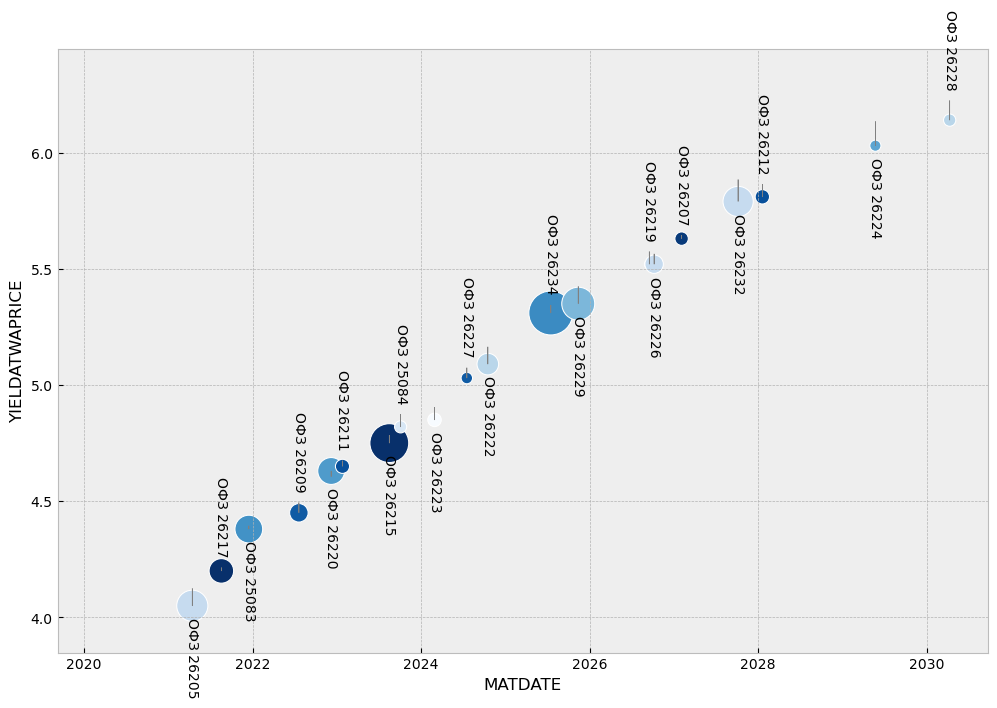

In [4]:
# Отрисовка графика доходности ОФЗ
fig = plt.figure()
ax = sns.scatterplot(data=df, x="MATDATE", y="YIELDATWAPRICE", size="VALTODAY", sizes=(50, 1000),
                     hue = "ACCRUEDINT_n", palette="Blues_r", legend=False)
ax.set(xlim=(datetime.datetime.today() - datetime.timedelta(days=355), None),
       ylim = (df["YIELDATWAPRICE"].min()*0.95, df["YIELDATWAPRICE"].max()*1.05))

ha_allign = ["right", "left"]
va_allign = ["top", "bottom"]

sign = 1
for point in range(0,df.shape[0]):
    c = (df.YIELDATPREVWAPRICE[point]-df.YIELDATWAPRICE[point])
    ax.arrow(df.MATDATE[point],         #x start point
             df.YIELDATWAPRICE[point],  #y start point
             0,                         #change in x
             c,                         #change in y
             ec='gray')                 #arrow edge color
    m = [
        min(df.YIELDATWAPRICE[point], df.YIELDATPREVWAPRICE[point])-0.05,
        max(df.YIELDATWAPRICE[point], df.YIELDATPREVWAPRICE[point])+0.05
    ]
    
    ax.text(df.MATDATE[point], m[point%2], df.SHORTNAME[point], horizontalalignment="center", 
            va=va_allign[point%2], color='black', rotation=-90)

    sign = -1*sign